In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('/content/sample_data/usa_dataset.csv',index_col='dates', parse_dates=True)
df.index.asfreq = 'MS'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2001-01-15 to 2022-10-15
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gasoline_price   262 non-null    float64
 1   crude_oil_Price  262 non-null    float64
dtypes: float64(2)
memory usage: 6.1 KB


In [ ]:
n_obs = 13
df_train, df_test = df[0:-n_obs], df[-n_obs:]

In [ ]:
def adf(x):
    res=adfuller(x)
    print('\033[0m','Test-Statistic:', res[0])
    print('\033[0m','P-values', res[1])
    if(res[1]<0.05):
        print('\033[1m','Stationary')
    else:
        print('\033[1m','Non-Stationary')

In [ ]:
for column in df_train:
    print(column)
    data=df_train[column]
    adf(data)

gasoline_price
 Test-Statistic: -3.0701964599955476
 P-values 0.028838855571353628
 Stationary
crude_oil_Price
 Test-Statistic: -2.8524598007270874
 P-values 0.05116215644012193
 Non-Stationary


In [ ]:
df_train_transformed = df_train.diff().dropna()

In [ ]:
for column in df_train_transformed:
    print(column)
    data=df_train_transformed[column]
    adf(data)

gasoline_price
 Test-Statistic: -7.63771794700722
 P-values 1.9324411924976387e-11
 Stationary
crude_oil_Price
 Test-Statistic: -10.38424469183463
 P-values 2.100160639706125e-18
 Stationary


In [ ]:
import numpy as np

maxlag=30
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train_transformed, variables = df_train_transformed.columns)

,gasoline_price_x,crude_oil_Price_x
gasoline_price_y,1.0000,0.0
crude_oil_Price_y,0.0001,1.0


In [ ]:
model = VAR(df_train_transformed)
for i in range(1,31):
    result = model.fit(i)
 

In [ ]:
results = model.fit(maxlags=12, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, Apr, 2023
Time:                     07:57:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.295786
Nobs:                     239.000    HQIC:                 -0.625788
Log likelihood:          -538.853    FPE:                   0.428332
AIC:                    -0.848529    Det(Omega_mle):        0.367567
--------------------------------------------------------------------
Results for equation gasoline_price
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.009995         0.008759            1.141           0.254
L1.gasoline_price         -0.219654         0.076385           -2.876           0.004
L1.crude_oil_Price         0.02

In [ ]:
lag_order = results.k_ar
lag_order

9

In [ ]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

gasoline_price : 1.98
crude_oil_Price : 1.98


In [ ]:
lag_order = results.k_ar

df_input = df_train_transformed.values[-lag_order:]
df_forecast = results.forecast(y=df_input, steps=n_obs)
df_forecast = (pd.DataFrame(df_forecast, index=df_test.index, columns=df_test.columns + '_pred'))

def invert_transformation(df, pred):
    forecast = df_forecast.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df_train, df_forecast)

combined = pd.concat([output['gasoline_price_pred'], df_test['gasoline_price']],axis=1)

In [ ]:
combined

,gasoline_price_pred,gasoline_price
dates,,
2021-10-15,3.115460,3.27
2021-11-15,3.014341,3.40
2021-12-15,2.960158,3.32
2022-01-15,2.952756,3.30
2022-02-15,2.941451,3.49
2022-03-15,2.969199,4.32
2022-04-15,3.021499,4.09
2022-05-15,3.029389,4.33
2022-06-15,3.099807,5.01


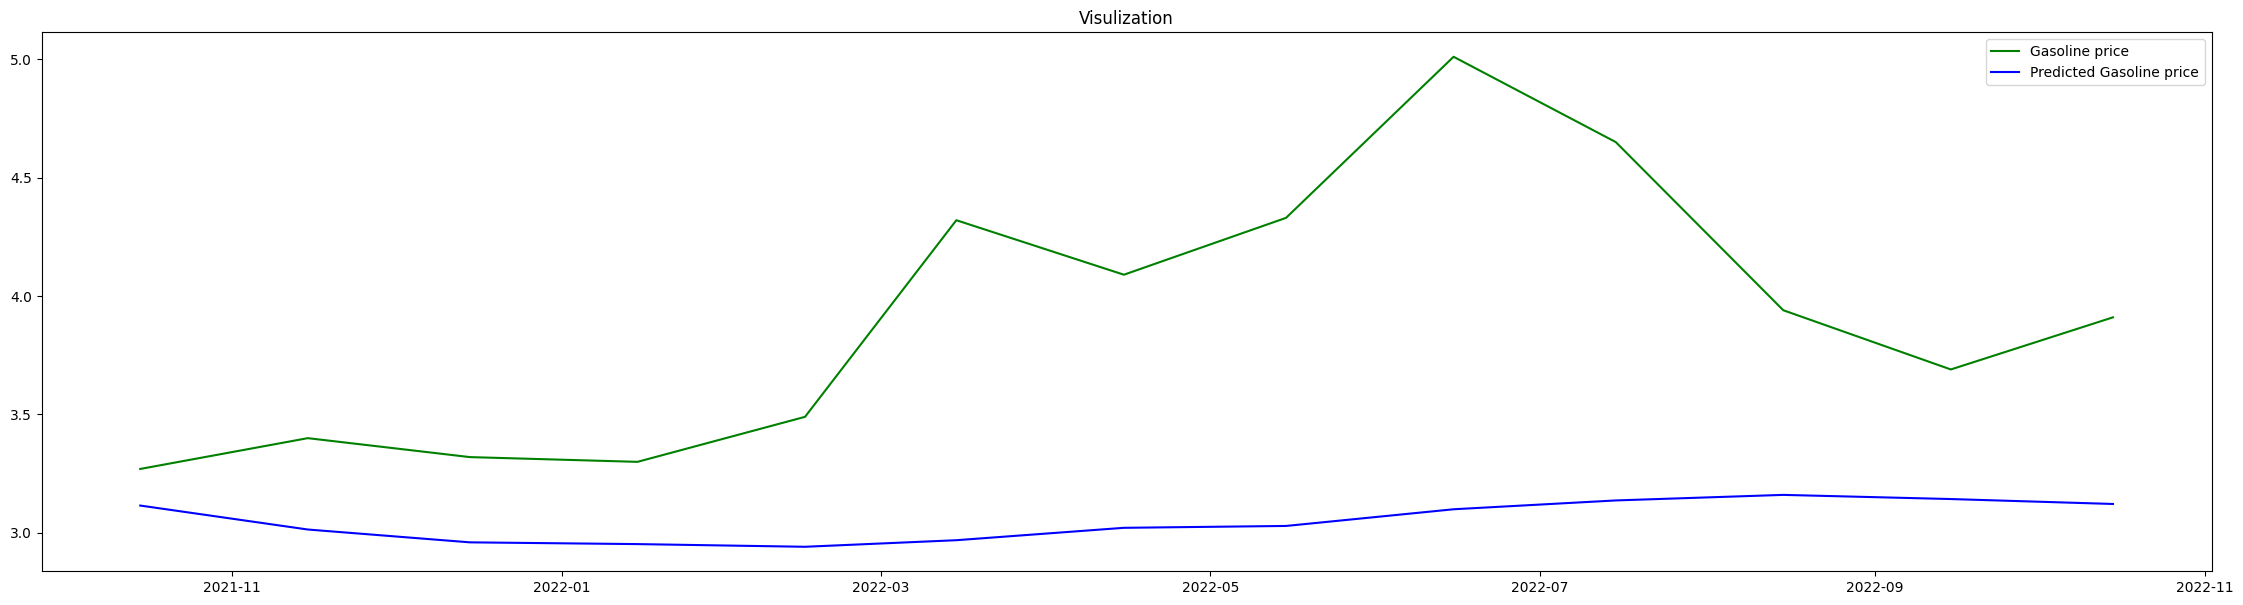

In [ ]:
gasoline=combined['gasoline_price']
pred_gas=combined['gasoline_price_pred']

plt.figure(figsize=(28,7))
fig=plt.figure(1)

std=plt.plot(gasoline,color='green',label='Gasoline price')
orig1=plt.plot(pred_gas,color='blue',label='Predicted Gasoline price')


plt.legend(loc='best')
plt.title('Visulization')
plt.show(block=False)

In [ ]:
combined=combined.reset_index()

In [ ]:
predicted_list=combined['gasoline_price_pred']

In [ ]:
predicted_list=predicted_list.to_numpy()

In [ ]:
predicted_list

array([3.11546033, 3.01434095, 2.96015783, 2.95275623, 2.94145092,
       2.96919948, 3.02149863, 3.0293887 , 3.09980744, 3.13707793,
       3.1605197 , 3.1429392 , 3.12215   ])

In [ ]:
t=pd.DataFrame()
t['gasoline_price']=combined['gasoline_price']

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
error = mean_squared_error(t, predicted_list)
print('Test MSE: %.3f' % error)

Test MSE: 0.988


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(t, predicted_list))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.994
